## Setup

In [25]:
%matplotlib widget

from pyCascade import probePost, physics
from matplotlib import pyplot as plt
import numpy as np

category =  "single_family"


In [26]:
############ CLUSTER ################
scratch_dir = '/scratch/users/nbachand/Cascade/city_block_cfd'
home_dir = '/home/users/nbachand/Cascade/city_block_cfd'

# ########### LOCAL ###################
# home_dir = '/home/nbachand/Documents/Cascade/city_block'
# scratch_dir = home_dir

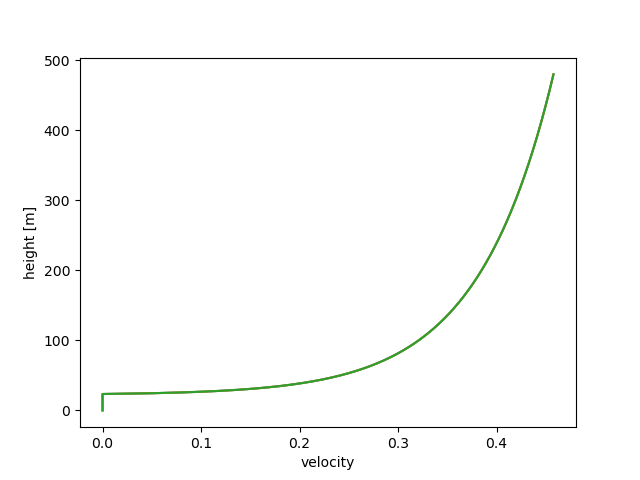

In [27]:
rho = 1.225
mu = 1.7894e-5
Re_tau = 43300
Lz =  480
hm = 20
fric_vel = Re_tau*mu/(hm*rho)

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = fric_vel*np.sqrt(1-disp/Lz)
vK_const = 0.4

LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'vK_const': vK_const,
    'Dt': .0675,
    'z_values' : np.linspace(0,Lz,Lz*10),
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

# checking against charles code
# approximate log law mean profile
y_scaled = (LES_params['z_values']-disp)/z_0
y_scaled = np.maximum(1.0, y_scaled)
ux = (shear_vel/vK_const)*np.log(y_scaled)

# physics_setup.plot_log_wind()

plt.plot(ux, LES_params['z_values'])
plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [28]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )


U infinity is 0.45768224669677254 with L = 480.0
flat plate Reynolds number is 15027242.29234871
wall spacing is 0.45603115286411516 for y+ of 500


In [29]:
physics_setup.LES_params['uStar']
physics_setup.LES_params['z_values'][330]
physics_setup.LES_params['log_wind'][330]



0.16842565916900132

In [30]:
velocity_scaling = 1/physics_setup.LES_params['log_wind'][330]
ventilation_scaling = velocity_scaling/(2.5**2)
                                        
norm_vel = lambda data_df : data_df*velocity_scaling
norm_vent = lambda data_df : data_df*ventilation_scaling

# R10

In [31]:
run = 10
qois = ['comp(u,0)','comp(u,2)']

probes = probePost.Probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut')
probes.get_locations(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/locations')

In [32]:
## 10 m flow statistics
10m_flow = probes.statistics(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[-10000:-1:1],
    quants = ['comp(u,0)','comp(u,2)' ],
    stack = probes.probe_stack[33],
    processing = [probePost.time_average],
    parrallel=True
    )

slicing took 0 seconds
INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 148 seconds
memorizing data took 5 seconds
processing data took 0 seconds


name              col_3-2   col_3-6   col_9-2   col_9-6
stack var                                              
33    comp(u,0)  0.182896  0.239525  0.199731  0.273147
      comp(u,2)  0.004541  0.002477  0.005090  0.000214

In [ ]:
10m_flow.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/10m_flow')

slicing took 0 seconds
INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 20 seconds
memorizing data took 5 seconds
processing data took 0 seconds
plotting took 183 seconds


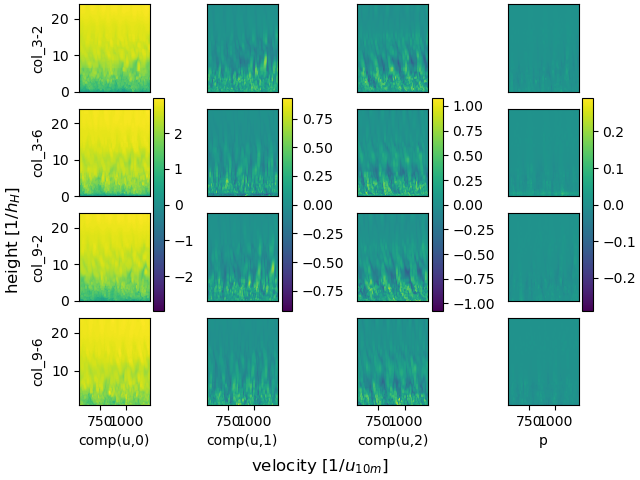

In [33]:
norm_data = lambda data_df : data_df*ventilation_scaling

plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : physics_setup.LES_params['Dt'],
    'stack span' : 'y',
    'xlabel': 'velocity $[1/u_{10m}]$',
    'ylabel' : r'height $[1/h_H]$',
    'ColorNorm': 'Centered',
    'veritcal scaling' : 1/20
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[-10000:-1:1],
    quants = ['comp(u,0)','comp(u,1)','comp(u,2)'],
    parrallel = True,
    plot_params = plot_params,
    processing = [norm_vel]
    )

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_history')

slicing took 0 seconds
INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 21 seconds
memorizing data took 6 seconds
processing data took 0 seconds


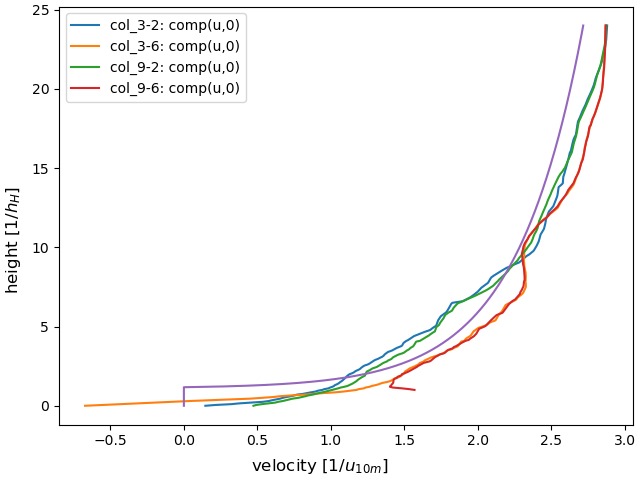

In [34]:
probes.profile_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[-10000:-1],
    quants = qois,
    # stack = np.arange(0,300),
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'velocity $[1/u_{10m}]$',
        'ylabel' : r'height $[1/h_H]$',
        'veritcal scaling' : 1/20
        },
    parrallel=True,
    processing = [norm_vel, probePost.time_average]
    )

plt.plot(norm_vel(physics_setup.LES_params['log_wind'])*sqrt(2)/2, LES_params['z_values']/20)

In [35]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_profile')

In [36]:
# probes.probe_stack

## X flow

slicing took 0 seconds
INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 120 seconds
memorizing data took 4 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:360: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 0 seconds
slicing took 0 seconds
reading data took 2645 seconds
memorizing data took 7 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:417: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 0 seconds
slicing took 0 seconds
reading data took 2 seconds
memorizing data took 6 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:417: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 0 seconds


name,zwindow_0-0,zwindow_0-1,zwindow_1-0,zwindow_1-1,zwindow_2-0,zwindow_2-1
var,,,,,,
"comp(u,0)",0.130506,0.181594,0.202258,0.296325,0.227774,0.341217


name,zwindow_0-0,zwindow_0-1,zwindow_1-0,zwindow_1-1,zwindow_2-0,zwindow_2-1
var,,,,,,
"comp(u,0)",0.010404,0.028042,0.017201,0.034076,0.02236,0.029217


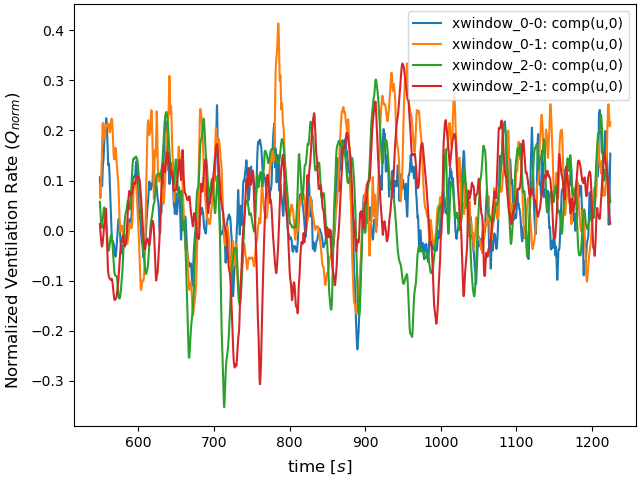

In [37]:
start = -10000
stop = -1
by = 1

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : physics_setup.LES_params['Dt'],
        },
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature],
    parrallel=True
    )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[-start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

display(x_mean)
display(x_rms)

In [42]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows')

x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean')
x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms')

## Z flow

slicing took 0 seconds
INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 23 seconds
memorizing data took 7 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:360: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 0 seconds
slicing took 0 seconds
reading data took 3 seconds
memorizing data took 4 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:417: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 0 seconds
slicing took 0 seconds
reading data took 1 seconds
memorizing data took 3 seconds


/home/groups/gorle/codes/pyCascade/pyCascade/probePost.py:417: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = data.loc[(stack,quants),:]


processing data took 0 seconds


name,xwindow_0-0,xwindow_0-1,xwindow_2-0,xwindow_2-1
var,,,,
"comp(u,2)",-0.171509,-0.024444,-0.108524,0.102169


name,xwindow_0-0,xwindow_0-1,xwindow_2-0,xwindow_2-1
var,,,,
"comp(u,2)",0.03814,0.045321,0.00851,0.008861


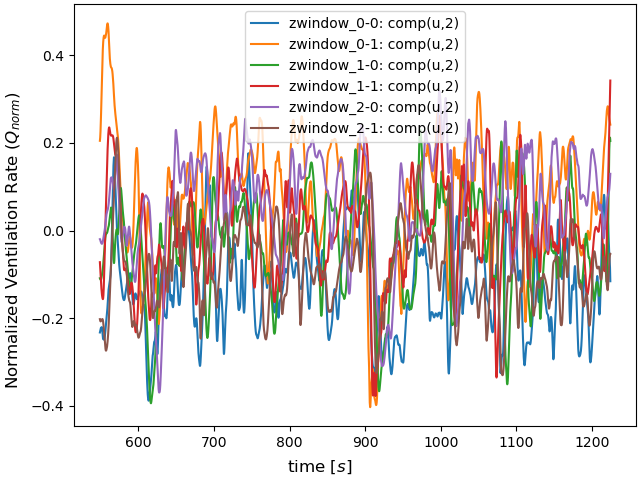

In [38]:
start = -10000
stop = -1
by = 1
norm_data = lambda data_df : data_df*ventilation_scaling

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : physics_setup.LES_params['Dt'],
        },
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature],
    parrallel=True
    )

## mean statistics
z_mean = ventilation_scaling * probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[-start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

display(z_mean)
display(z_rms)

In [43]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindow')

z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean')
z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms')